In [2]:
import os
import json
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import matplotlib.pyplot as plt
from PIL import Image
import pytesseract
from sklearn.metrics import precision_recall_fscore_support
from Levenshtein import distance as levenshtein_distance
#from rapidfuzz import string_metric
from ultralytics import YOLO

In [3]:
# Constants
DATA_DIR = 'TextOCR/train_val_images/train_images'
ANNOT_PATH = 'TextOCR/annot.csv'
IMAGE_OUTPUT_DIR = 'dataset/images'
LABEL_OUTPUT_DIR = 'dataset/labels'
SUBSET_RATIO = 0.02

# Prepare directories
def prepare_directories(image_output_dir, label_output_dir):
    os.makedirs(image_output_dir, exist_ok=True)
    os.makedirs(label_output_dir, exist_ok=True)
    print(f"Directories created at {image_output_dir} and {label_output_dir}")

# Create directories for images and labels
prepare_directories(IMAGE_OUTPUT_DIR, LABEL_OUTPUT_DIR)


Directories created at dataset/images and dataset/labels


In [4]:
# Function to split and reduce dataset size
def reduce_dataset_size(image_ids, subset_ratio=0.02):
    train_ids, test_ids = train_test_split(image_ids, test_size=0.03, random_state=42)
    train_ids, val_ids = train_test_split(train_ids, test_size=0.2, random_state=42)
    small_train_ids, _ = train_test_split(train_ids, test_size=1-subset_ratio, random_state=42)
    small_val_ids, _ = train_test_split(val_ids, test_size=1-subset_ratio, random_state=42)
    small_test_ids, _ = train_test_split(test_ids, test_size=1-subset_ratio, random_state=42)
    return small_train_ids, small_val_ids, small_test_ids

# Load and split data
annot_df = pd.read_csv(ANNOT_PATH)
image_ids = annot_df['image_id'].unique()
small_train_ids, small_val_ids, small_test_ids = reduce_dataset_size(image_ids, SUBSET_RATIO)

In [5]:
# Function to convert bounding boxes to YOLO format
def convert_to_yolo_format(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[2]) / 2.0
    y = (box[1] + box[3]) / 2.0
    w = box[2] - box[0]
    h = box[3] - box[1]
    x = max(0, min(1, x * dw))
    y = max(0, min(1, y * dh))
    w = max(0, min(1, w * dw))
    h = max(0, min(1, h * dh))
    return (x, y, w, h)
    
# Copy images and create label files in YOLO format
def process_images_and_labels(image_ids, annot_df):
    for image_id in image_ids:
        img_path = os.path.join(DATA_DIR, f'{image_id}.jpg')
        img = cv2.imread(img_path)
        h, w, _ = img.shape
        
        new_img_path = os.path.join(IMAGE_OUTPUT_DIR, f'{image_id}.jpg')
        cv2.imwrite(new_img_path, img)
        
        records = annot_df[annot_df['image_id'] == image_id]
        boxes = records['bbox'].apply(json.loads).tolist()
        boxes = [[b[0], b[1], b[0] + b[2], b[1] + b[3]] for b in boxes]
        
        label_file_path = os.path.join(LABEL_OUTPUT_DIR, f'{image_id}.txt')
        with open(label_file_path, 'w') as f:
            for box in boxes:
                yolo_box = convert_to_yolo_format((w, h), box)
                f.write(f'0 {yolo_box[0]} {yolo_box[1]} {yolo_box[2]} {yolo_box[3]}\n')

In [6]:
# Process images and labels
process_images_and_labels(image_ids, annot_df)


KeyboardInterrupt: 

In [7]:
# Create the text files listing paths to images
def create_text_file(image_ids, file_path):
    with open(file_path, 'w') as f:
        for image_id in image_ids:
            img_path = os.path.join(os.getcwd(), IMAGE_OUTPUT_DIR, f'{image_id}.jpg')
            f.write(f'{img_path}\n')

In [8]:
create_text_file(small_train_ids, 'dataset/train.txt')
create_text_file(small_val_ids, 'dataset/val.txt')
create_text_file(small_test_ids, 'dataset/test.txt')

print("Text files created successfully.")

Text files created successfully.


In [9]:
class TextOCRDataset(Dataset):
    def __init__(self, image_ids, annot_df, data_dir, transforms=None, target_size=(640, 640)):
        self.image_ids = image_ids
        self.annot_df = annot_df
        self.data_dir = data_dir
        self.transforms = transforms
        self.target_size = target_size

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.data_dir, f'{image_id}.jpg')
        img = Image.open(img_path).convert("RGB")
        original_width, original_height = img.size

        # Apply transformations
        if self.transforms:
            img = self.transforms(img)

        # Rescale bounding boxes to match the resized image dimensions
        records = self.annot_df[self.annot_df['image_id'] == image_id]
        boxes = records['bbox'].apply(json.loads).tolist()
        boxes = [[b[0] * self.target_size[0] / original_width, 
                  b[1] * self.target_size[1] / original_height,
                  (b[0] + b[2]) * self.target_size[0] / original_width,
                  (b[1] + b[3]) * self.target_size[1] / original_height] for b in boxes]

        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'labels': torch.ones((len(boxes),), dtype=torch.int64)
        }
        return img, target

    def __len__(self):
        return len(self.image_ids)

# Data Transforms
transform = T.Compose([
    T.Resize((640, 640)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#    T.RandomHorizontalFlip(),
    T.ToTensor()
])


In [10]:
# Data Loaders
small_train_dataset = TextOCRDataset(small_train_ids, annot_df, DATA_DIR, transforms=transform)
val_dataset = TextOCRDataset(small_val_ids, annot_df, DATA_DIR, transforms=transform)
test_dataset = TextOCRDataset(small_test_ids, annot_df, DATA_DIR, transforms=transform)

def collate_fn(batch):
    return tuple(zip(*batch))

small_train_loader = DataLoader(small_train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)


In [11]:
# Print dataset sizes to verify reduction
print(f"Training dataset size: {len(small_train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 337
Validation dataset size: 84
Test dataset size: 13


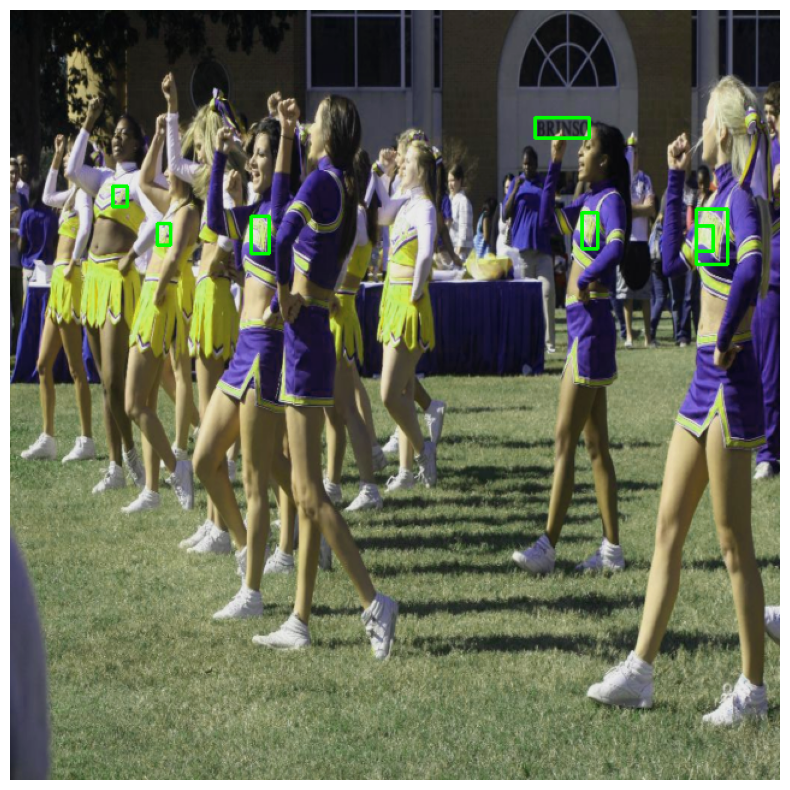

OverflowError: Python integer -25 out of bounds for uint8

In [12]:
def visualize_data(dataset, idx=0, color=(0, 255, 0), thickness=2, figsize=(10, 10)):
    img, target = dataset[idx]
    boxes = target['boxes'].cpu().numpy()
    img = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = np.ascontiguousarray(img)

    # Draw bounding boxes
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)

    # Display the image with bounding boxes using matplotlib
    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Visualize some training data
visualize_data(small_train_dataset, idx=0)
visualize_data(small_train_dataset, idx=1)

In [12]:
# Train YOLOv3
model = YOLO('yolov3u.pt')
model.train(data='config.yaml', epochs=2, imgsz=320, batch=2, device='cpu')

Ultralytics 8.3.17  Python-3.11.9 torch-2.4.1+cpu CPU (11th Gen Intel Core(TM) i3-1125G4 2.00GHz)
engine\trainer: task=detect, mode=train, model=yolov3u.pt, data=config.yaml, epochs=2, time=None, patience=100, batch=2, imgsz=320, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train14, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes

train: Scanning C:\Users\uzair\deep-machine-learning\Project\dataset\labels... 337 images, 0 backgrounds, 0 corrupt: 10


train: New cache created: C:\Users\uzair\deep-machine-learning\Project\dataset\labels.cache


val: Scanning C:\Users\uzair\deep-machine-learning\Project\dataset\labels... 84 images, 0 backgrounds, 0 corrupt: 100%|


val: New cache created: C:\Users\uzair\deep-machine-learning\Project\dataset\labels.cache
Plotting labels to runs\detect\train14\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 84 weight(decay=0.0), 91 weight(decay=0.0005), 90 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to runs\detect\train14
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2         0G      2.699      2.378      1.466         56        320: 100%|██████████| 169/169 [18:08<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:03

                   all         84       2730      0.195      0.152     0.0653     0.0211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2         0G      2.692      1.846      1.391        128        320: 100%|██████████| 169/169 [17:27<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:55

                   all         84       2730     0.0829      0.182     0.0324     0.0122



2 epochs completed in 0.642 hours.
Optimizer stripped from runs\detect\train14\weights\last.pt, 207.7MB
Optimizer stripped from runs\detect\train14\weights\best.pt, 207.7MB

Validating runs\detect\train14\weights\best.pt...
Ultralytics 8.3.17  Python-3.11.9 torch-2.4.1+cpu CPU (11th Gen Intel Core(TM) i3-1125G4 2.00GHz)
YOLOv3 summary (fused): 226 layers, 103,665,011 parameters, 0 gradients, 282.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:55


                   all         84       2730      0.194      0.152     0.0651      0.021
Speed: 1.2ms preprocess, 619.1ms inference, 0.0ms loss, 7.9ms postprocess per image
Results saved to runs\detect\train14


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000015201278410>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [13]:
import logging
# Set the Tesseract executable path
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

def recognize_text(model, dataset):
    detected_texts = []  # Initialize list to store detected texts
    
    for img_index, (img, _) in enumerate(dataset):
        # Convert the tensor to a numpy array if necessary
        img_np = img.permute(1, 2, 0).numpy()  # Assuming img is a PyTorch tensor
        logging.info(f"Processing image {img_index} with shape: {img_np.shape}")
        
        # Perform detection using the model
        results = model(img_np)  # Call the model directly
        
        # Log the results
        logging.info(f"Image {img_index} results: {results}")

        # Check if there are detections
        if not results or len(results[0].boxes.xyxy) == 0:
            logging.warning(f"No detections for image {img_index}")
            detected_texts.append([])  # Append empty list for this image
            continue  # Skip to the next image

        # Parse the results
        bboxes = results[0].boxes.xyxy.numpy()  # Get bounding boxes (x1, y1, x2, y2)
        logging.info(f"Detected bounding boxes for image {img_index}: {bboxes}")

        texts = []
        for bbox in bboxes:  # Iterate through each detected bounding box
            text = extract_text_from_bbox(img_np, bbox)
            if text:  # Only append if text is not empty
                texts.append(text)
        
        detected_texts.append(texts)
    
    return detected_texts


In [14]:
# Recognize text
detected_texts = recognize_text(model, test_dataset)

NameError: name 'model' is not defined

In [ ]:
# Check the detected texts
print(f"Detected texts: {detected_texts}")

In [44]:
# Visualize some test data with recognized text
def visualize_recognition(dataset, detected_texts, idx=0):
    # Get the image and its associated data
    img, _ = dataset[idx]
    
    # Convert the image from tensor to a numpy array and adjust the range
    img_np = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

    # Check if detected_texts for the current index is not empty
    if idx < len(detected_texts) and detected_texts[idx]:
        # Iterate over each bounding box and the corresponding detected text
        for bbox, text in detected_texts[idx]:
            # Extract bounding box coordinates
            x1, y1, x2, y2 = map(int, bbox[:4])
            
            # Draw the bounding box if within image dimensions
            if (0 <= x1 < img_np.shape[1]) and (0 <= y1 < img_np.shape[0]) and (0 <= x2 < img_np.shape[1]) and (0 <= y2 < img_np.shape[0]):
                cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
                # Put the recognized text near the bounding box
                cv2.putText(img_np, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            else:
                print(f"Warning: Bounding box {bbox} is out of image bounds.")
    else:
        print(f"No detected texts available for index {idx}.")

    # Display the image with the bounding boxes and recognized text
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


In [50]:
print(f"Test dataset length: {len(test_dataset)}")
print(f"Detected texts length: {len(detected_texts)}")
print("Detected texts:", detected_texts)
idx = 0  # Change this to the index you want to inspect
if idx < len(detected_texts):
    print(f"Detected texts at index {idx}:", detected_texts[idx])
else:
    print(f"No detected texts for index {idx} as it is out of bounds.")

Test dataset length: 13
Detected texts length: 300
Detected texts: ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 

No detected texts available for index 10.


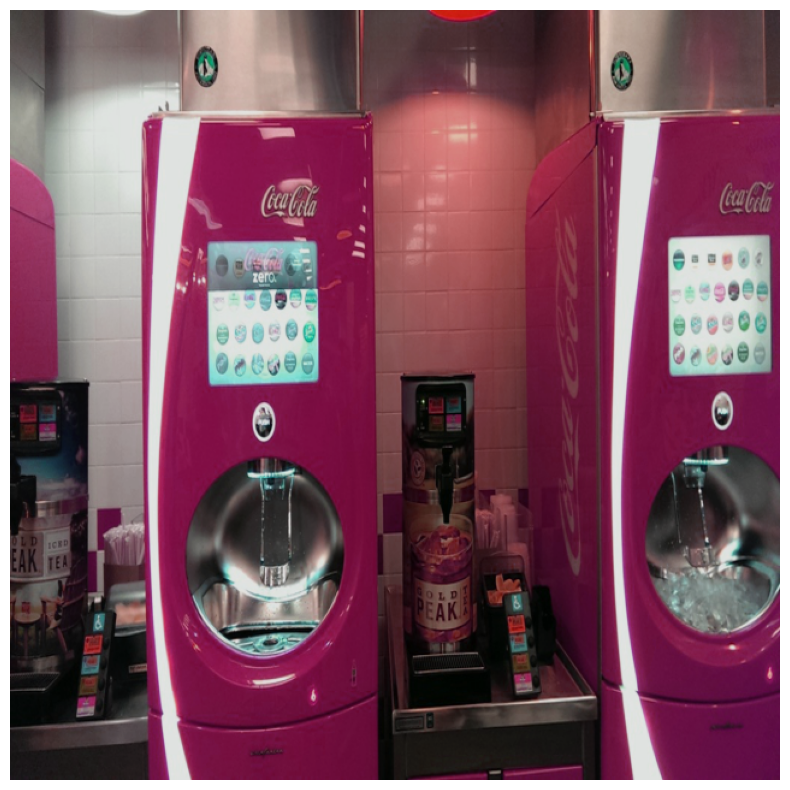

In [51]:
# Example usage with idx=1
visualize_recognition(test_dataset, detected_texts, idx=10)

In [32]:
# Define evaluation metrics
def l2_loss(pred_boxes, true_boxes):
    return torch.nn.functional.mse_loss(pred_boxes, true_boxes)

In [33]:
def evaluate_text_extraction(true_texts, pred_texts):
    levenshtein_distances = []
    cer = []
    wer = []
    
    for true_text, pred_text in zip(true_texts, pred_texts):
        levenshtein_distances.append(levenshtein_distance(true_text, pred_text))
        cer.append(string_metric.levenshtein(true_text, pred_text) / len(true_text) if len(true_text) > 0 else 0)
        wer.append(string_metric.levenshtein(true_text.split(), pred_text.split()) / len(true_text.split()) if len(true_text.split()) > 0 else 0)
    
    avg_levenshtein = np.mean(levenshtein_distances)
    avg_cer = np.mean(cer)
    avg_wer = np.mean(wer)
    
    return avg_levenshtein, avg_cer, avg_wer

In [34]:
def evaluate_text_detection(true_labels, pred_labels):
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='binary')
    return precision, recall, f1

In [52]:
# Function to perform evaluation on the test dataset
def evaluate_model(model, test_loader, device='cpu'):
    model.to(device)
    model.eval()
    
    all_true_boxes = []
    all_pred_boxes = []
    all_true_texts = []
    all_pred_texts = []
    all_true_labels = []
    all_pred_labels = []
    
    with torch.no_grad():
        for imgs, targets in test_loader:
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            outputs = model(imgs)
            
            for img, target, output in zip(imgs, targets, outputs):
                true_boxes = target['boxes']
                pred_boxes = output['boxes']
                
                for true_box, pred_box in zip(true_boxes, pred_boxes):
                    all_true_boxes.append(true_box.cpu().numpy())
                    all_pred_boxes.append(pred_box.cpu().numpy())
                    
                    img_np = img.cpu().numpy().transpose(1, 2, 0)
                    true_text = extract_text_from_bbox(img_np, true_box.cpu().numpy())
                    pred_text = extract_text_from_bbox(img_np, pred_box.cpu().numpy())
                    
                    all_true_texts.append(true_text)
                    all_pred_texts.append(pred_text)
                    
                    all_true_labels.append(1)  # Assuming all targets are text
                    all_pred_labels.append(1 if output['scores'][0] > 0.5 else 0)
    

In [15]:
 # Calculate L2 loss for bounding boxes
l2_loss_value = l2_loss(torch.tensor(all_pred_boxes), torch.tensor(all_true_boxes))

NameError: name 'l2_loss' is not defined

In [38]:
    # Evaluate text extraction
    avg_levenshtein, avg_cer, avg_wer = evaluate_text_extraction(all_true_texts, all_pred_texts)
    

NameError: name 'all_true_texts' is not defined

In [39]:
   # Evaluate text detection
    precision, recall, f1_score = evaluate_text_detection(all_true_labels, all_pred_labels)
    
    print(f"L2 Loss for bounding boxes: {l2_loss_value}")
    print(f"Average Levenshtein Distance: {avg_levenshtein}")
    print(f"Character Error Rate (CER): {avg_cer}")
    print(f"Word Error Rate (WER): {avg_wer}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1_score}")

IndentationError: unexpected indent (258854193.py, line 2)

In [ ]:
# Load the model
model = YOLO('path_to_trained_model.pt')

# Evaluate the model
evaluate_model(model, test_loader)

New https://pypi.org/project/ultralytics/8.3.18 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=yolov3u.pt, data=config.yaml, epochs=2, time=None, patience=100, batch=2, imgsz=320, save=True, save_period=-1, cache=False, device=cpu, workers=0, project=None, name=train142222222, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

train: Scanning C:\Users\uzair\deep-machine-learning\Project\dataset\labels... 337 images, 0 backgrounds, 0 corrupt: 10


train: New cache created: C:\Users\uzair\deep-machine-learning\Project\dataset\labels.cache


val: Scanning C:\Users\uzair\deep-machine-learning\Project\dataset\labels... 84 images, 0 backgrounds, 0 corrupt: 100%|

val: New cache created: C:\Users\uzair\deep-machine-learning\Project\dataset\labels.cache


Plotting labels to runs\detect\train142222222\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 84 weight(decay=0.0), 91 weight(decay=0.0005), 90 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to runs\detect\train142222222
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2         0G      1.517     0.8312      1.043        202        320:  22%|██▏       | 38/169 [05:08<17:43,  8


KeyboardInterrupt: 